# Experiments for Complete Graph

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

from collections import OrderedDict
import logging
import math

from matplotlib import pyplot as plt
import networkx as nx
import numpy as np

import torch
from torchdiffeq import odeint, odeint_adjoint

sys.path.append('../')

# Baseline imports
from gd_controller import AdjointGD
from dynamics import ForwardKuramotoDynamics, BackwardKuramotoDynamics

# Nodec imports
from neural_net import EluTimeControl, TrainingAlgorithm

# Various Utilities
from utilities import evaluate, calculate_critical_coupling_constant, comparison_plot, state_plot
from nnc.helpers.torch_utils.oscillators import order_parameter_cos

logging.getLogger().setLevel(logging.CRITICAL) # set to info to look at loss values etc.

## Load graph parameters
Basic setup for calculations, graph, number of nodes, etc.

In [2]:

dtype = torch.float32
device = 'cpu'
graph_type = 'complete_graph'
adjacency_matrix = torch.load('../../data/'+graph_type+'_adjacency.pt')
parameters = torch.load('../../data/parameters.pt')
# driver vector is a column vector with 1 value for driver nodes
# and 0 for non drivers.
driver_vector = torch.ones([adjacency_matrix.shape[0],1])

result_folder = '../../results/' + graph_type + os.path.sep
os.makedirs(result_folder, exist_ok=True)

## Load dynamics parameters
Load natural frequencies and initial states which are common for all graphs and also calculate the coupling constant which is different per graph. We use a coupling constant value that is $10%$ of the critical coupling constant value.

In [3]:
total_time = parameters['total_time']
natural_frequencies = parameters['natural_frequencies']

critical_coupling_constant = calculate_critical_coupling_constant(adjacency_matrix, natural_frequencies)
coupling_constant = 0.1*critical_coupling_constant
theta_0 = parameters['theta_0']

## Initialize DynamicsLoad dynamics 
Here we initialize the Kuramoto dynamics, both forward and backward (adjoint system). The backward system is used for the control baseline of the ajoint gradient, whereas the forward dynamics are used for both control models.

In [4]:
forward_dynamics = ForwardKuramotoDynamics(adjacency_matrix, 
                                           driver_vector, 
                                           coupling_constant, 
                                           natural_frequencies
                                          )
backward_dynamics = BackwardKuramotoDynamics(adjacency_matrix, 
                                             driver_vector, 
                                             coupling_constant, 
                                             natural_frequencies
                                            )

## No Control
Here we run the dynamics without control to determine the evolution of $r(t)$ and the states when no control is applied. Since the control is multiplicative, no control tranlsates to using $u(t) = 1, \forall t$.

In [5]:
no_control = lambda y,t: torch.tensor([[1]]).float()

control_trajectory, state_trajectory =\
evaluate(forward_dynamics, theta_0, no_control, total_time, 100)
no_control = torch.cat(control_trajectory).squeeze().cpu().detach().numpy()
no_control_states = torch.cat(state_trajectory).cpu().detach().numpy()
no_control_r = order_parameter_cos(torch.tensor(no_control_states)).cpu().numpy()
no_control_e = ((no_control)**2).cumsum(-1)
np.save(result_folder + 'no_control_signal', no_control)
np.save(result_folder + 'no_control_states', no_control_states)
np.save(result_folder + 'no_control_syn_param', no_control_r)

## Adjoint Gradient Control
Here we train the ADG control on the dynamics. The hyperparameters may differ per graph, but in general we start our parameter search from the default parameters discussed in the original paper:

Biccari, Umberto, and Enrique Zuazua. "A stochastic approach to the synchronization of coupled oscillators." arXiv preprint arXiv:2002.04472 (2020).


In [6]:
import logging
logging.getLogger().setLevel(logging.INFO)
torch.manual_seed(1)
baseline_control = AdjointGD(
    forward_dynamics,
    backward_dynamics,
    theta_0,
    n_timesteps=100,
    total_time=total_time,
    learning_rate=5,
    beta=1e-07,
    iterations=2,
    control_change_tolerance=1e-07,
    progress_bar=None,
    ode_int_kwargs={'method':'dopri5', 
                    # 'options' : {'step_size' : 0.01}, For RK4
                   },
)
# we save the trained model.
torch.save(baseline_control.u_baseline, result_folder + 'baseline_signal.pt')

INFO:root:GD step loss: 2922323.0
INFO:root:GD step loss: 24.89414405822754


### ADG Evaluation
Below we evaluate the adjoint gradient with fixed step intervals.

In [7]:
control_trajectory, state_trajectory =\
evaluate(forward_dynamics, theta_0, baseline_control, total_time, 100)
adj_control = torch.cat(control_trajectory).squeeze().cpu().detach().numpy()
adj_states = torch.cat(state_trajectory).cpu().detach().numpy()
adj_r = order_parameter_cos(torch.tensor(adj_states)).cpu().numpy()
adj_e = (adj_control**2).cumsum(-1)
np.save(result_folder + 'agd_control_signal', adj_control)
np.save(result_folder + 'agd_states', adj_states)
np.save(result_folder + 'agd_syn_param', adj_r)

## NODEC
We now train NODEC with a shallow neural network. We initialize the parameters in a deterministic manner, and use stochastic gradient descent to train it. The learning rate, number of epochs and neural architecture may change per graph.

In [8]:
neural_net = EluTimeControl([2])
for parameter in neural_net.parameters():
    parameter.data = torch.ones_like(parameter.data)/1000 # deterministic init!
train_algo = TrainingAlgorithm(neural_net, forward_dynamics)
best_model = train_algo.train(theta_0, total_time, epochs=2, lr=0.4)


INFO:root:Training epoch: 0
INFO:root:Current loss is: 19786.4921875
INFO:root:Training epoch: 1
INFO:root:Current loss is: 0.388111412525177


### NODEC Evaluation
we evalaute NODEC by using the same methodology we used for ADG control.

In [9]:
control_trajectory, state_trajectory =\
evaluate(forward_dynamics, theta_0, best_model, total_time, 100)
nn_control = torch.cat(control_trajectory).squeeze().cpu().detach().numpy()
nn_states = torch.cat(state_trajectory).cpu().detach().numpy()
nn_e = (nn_control**2).cumsum(-1)
nn_r = order_parameter_cos(torch.tensor(nn_states)).cpu().numpy()
torch.save(best_model.state_dict(), result_folder + 'best_model.pt')
np.save(result_folder + 'nodec_control_signal', nn_control)
np.save(result_folder + 'nodec_states', nn_states)
np.save(result_folder + 'nodec_syn_param', nn_r)


## Comparison and Evaluation
We compare order parameter, energy and state evolution for the control methods.
The plots below show individual states and energy/order parameter comparisons between ADG and NODEC.

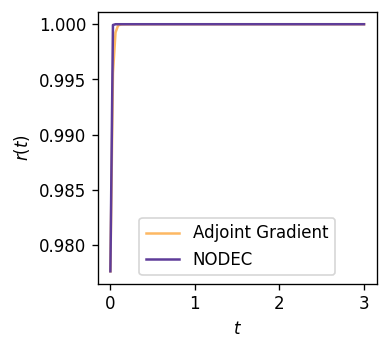

In [10]:
fig = comparison_plot(nn_r, adj_r, np.linspace(0, total_time, adj_r.shape[0]), '$r(t)$')
fig.savefig(result_folder + 'sync_param.pdf')

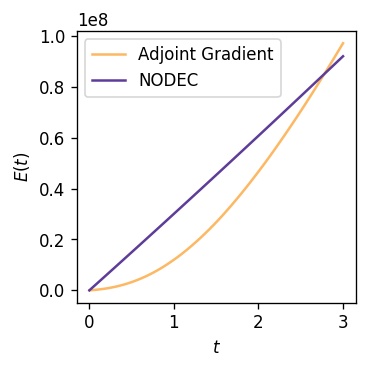

In [11]:
fig = comparison_plot(nn_e, adj_e, np.linspace(0, total_time, adj_e.shape[0]), '$E(t)$', legend_loc='upper left')
fig.savefig(result_folder + 'energy.pdf')

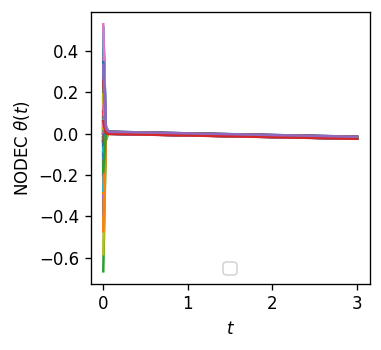

In [12]:
state_plot(nn_states, np.linspace(0, total_time, nn_states.shape[0]), "NODEC $\\theta (t)$")
fig.savefig(result_folder + 'nodec_states.pdf')

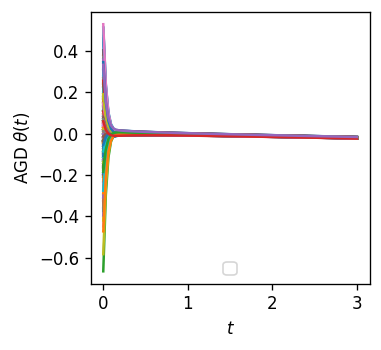

In [13]:
state_plot(adj_states, np.linspace(0, total_time, adj_states.shape[0]), "AGD $\\theta (t)$")
fig.savefig(result_folder + 'adj_states.pdf')

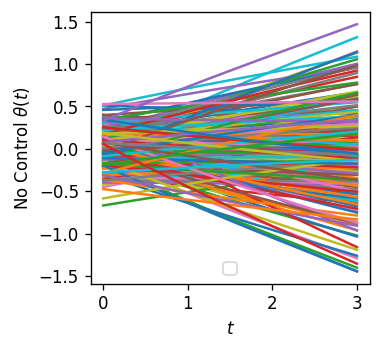

In [14]:
fig = state_plot(no_control_states, np.linspace(0, total_time, no_control_states.shape[0]), "No Control $\\theta (t)$")
fig.savefig(result_folder + 'no_control_states.pdf')

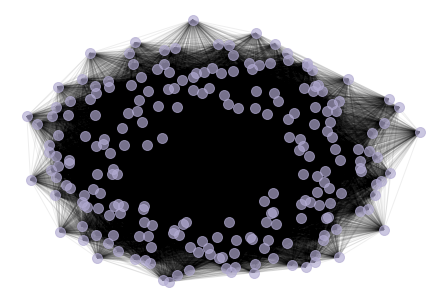

In [15]:
G = nx.from_numpy_matrix(adjacency_matrix.cpu().detach().numpy())
fig = nx.draw(G, nx.kamada_kawai_layout(G), node_size=100, node_color='#b2abd2aa', edge_color='#00000011')
plt.savefig(result_folder + 'graph.pdf')